In [1]:
import torch
import sys
from data import get_data, gen_label
from tqdm import tqdm
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
import cv2

slidingWindow = 30

class Process:
    def __init__(self,WindowSize):
        self.delay = 1
        self.slidingWindow = WindowSize
        self.createMatrix()

    def createMatrix(self):  
#         mat = np.random.rand(self.slidingWindow,self.slidingWindow)
#         self.TimeMatrix = torch.from_numpy(np.tril(mat,-1*self.delay))
        mat = np.random.rand(self.slidingWindow)
        self.TimeMatrix = torch.from_numpy(mat.reshape(1,self.slidingWindow))
        self.OneHotMatrix = torch.from_numpy(np.arange(0,10,1.0).reshape(10,1))

    def GetResult(self,labelBatch):
        onehot = torch.nn.functional.one_hot(labelBatch, 10).double()
#         onehot = self.make_one_hot(labelBatch,10)
        res = torch.mm(self.TimeMatrix,onehot)
    
        res = torch.mm(res,self.OneHotMatrix)
        res[0] = res[0]/40
        return res

    def make_one_hot(self,input, num_classes):
        """Convert class index tensor to one hot encoding tensor.
        Args:
             input: A tensor of shape [bs, 1, *]
             num_classes: An int of number of class
        Returns:
            A tensor of shape [bs, num_classes, *]
        """
        input.unsqueeze_(1)
        shape = np.zeros((input.shape[0],num_classes))
        result = torch.from_numpy(shape)
        result = result.scatter_(1, input, 1)
        return result
    
    def CalAcc(self,outputs,labels):
        bias = 0
        for i in range(outputs.shape[0]):
            for j in range(outputs.shape[1]):
                bias += pow((outputs[i][j]-labels[i][j]),2)
        bias/=(outputs.shape[0]*outputs.shape[1])
        print("average bias:",bias)


class CLSTMModel(torch.nn.Module):
    def __init__(self,slidingWindow):
        super(CLSTMModel, self).__init__()
        self.feature_num = 512
        self.cnn_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(512, self.feature_num)
        )

#         model = models.resnet18(pretrained=True)
# #         model.fc = nn.Identity()
#         self.cnn_layer = model
#         for p in self.parameters():
#             p.requires_grad=False
#         self.cnn_layer.fc = nn.Linear(512,self.feature_num)
        self.slidingWindow = slidingWindow
        self.lstm = nn.LSTM(self.feature_num,self.feature_num*2,1,batch_first=True)
        self.fc = nn.Linear(self.feature_num*2,1)
        self.slidingFc = nn.Linear(slidingWindow,1)
        
        
    def forward(self, x):
        cnn_x = self.cnn_layer(x)
        batch = torch.zeros([0,self.slidingWindow,self.feature_num])
        batch = batch.cuda()
        for i in range(cnn_x.shape[0]-self.slidingWindow):
            piece = cnn_x[i:i+self.slidingWindow].view(1,self.slidingWindow,self.feature_num)
            batch = torch.cat((batch,piece))
        # print("cnn_out",batch)
        # print(batch)
        # batch = self.sig(batch)
        x,hidden = self.lstm(batch)
        b,s,h = x.shape
        x = x.reshape(s*b, h) # 转换成线性层的输入格式
        x = self.fc(x)
        x = x.reshape(b,s)
        x = self.slidingFc(x)
        x = x.view(b, -1)
        return x    


model = CLSTMModel(slidingWindow).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=5e-5)
batch_size = 256
epochs = 10
MatrixClass = Process(slidingWindow)
pbar = tqdm(range(1, epochs+1))
gt = []
pred= []

gen_label(slidingWindow, batch_size, False)  # 改变参数需要重新生成label，设reset=True

train_loader, test_loader = get_data(slidingWindow, batch_size)
for epoch in pbar:
    running_loss = 0.0
    running_correct = 0
    print("Epoch {}/{}".format(epoch, epochs))
    print("-"*10)    

    for batch_index, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        labels = labels[slidingWindow:len(labels)].cuda()
        # perior_result = torch.zeros([0,1])
        # perior_result = perior_result.cuda()
        # for i in range(len(labels)-slidingWindow):
        #     result = MatrixClass.GetResult(labels[i:i+slidingWindow])
        #     result = result.float()
        #     result = result.cuda()
        #     perior_result = torch.cat((perior_result,result.view(1,1)))
        #     # image_sequence[i] = images[i:i+slidingWindow]
        if labels.shape[0]!=batch_size-slidingWindow:
            print(labels.shape)
            continue
        # image_sequence = image_sequence.cuda()
        outputs = model(images)
        # print(outputs)

        # MatrixClass.CalAcc(outputs,perior_result)
        # print(perior_result.shape,image_sequence.shape)
        optimizer.zero_grad()
        loss = criterion(outputs.squeeze(1), labels)
        loss.backward()
        pbar.set_postfix({'train loss' : '{0:1.5f}'.format(loss)})
        optimizer.step()
        cost = loss.item()
        # print("train lost:",cost)
        # break
        # print(cost)


  0%|          | 0/10 [00:00&lt;?, ?it/s, train loss=1.31282]Epoch 1/10
----------
 10%|█         | 1/10 [00:24&lt;03:42, 24.72s/it, train loss=0.03911]torch.Size([66])
Epoch 2/10
----------
 20%|██        | 2/10 [00:49&lt;03:17, 24.68s/it, train loss=0.03911]torch.Size([66])
Epoch 3/10
----------
 30%|███       | 3/10 [01:14&lt;02:52, 24.67s/it, train loss=0.03651]torch.Size([66])
Epoch 4/10
----------
 40%|████      | 4/10 [01:38&lt;02:27, 24.66s/it, train loss=0.03313]torch.Size([66])
Epoch 5/10
----------
 50%|█████     | 5/10 [02:03&lt;02:03, 24.67s/it, train loss=0.03224]torch.Size([66])
Epoch 6/10
----------
 60%|██████    | 6/10 [02:28&lt;01:38, 24.69s/it, train loss=0.02459]torch.Size([66])
Epoch 7/10
----------
 70%|███████   | 7/10 [02:52&lt;01:14, 24.72s/it, train loss=0.02559]torch.Size([66])
Epoch 8/10
----------
 80%|████████  | 8/10 [03:17&lt;00:49, 24.75s/it, train loss=0.02431]torch.Size([66])
Epoch 9/10
----------
 90%|█████████ | 9/10 [03:42&lt;00:24, 24.78s/it, tra

In [2]:
with torch.no_grad():
    for batch_index, (images, labels) in enumerate(test_loader):
        # perior_result = torch.zeros([0,1])
        # perior_result = perior_result.cuda()
        labels = labels[slidingWindow:len(labels)].cuda()
        images = images.cuda()
        # for i in range(len(labels)-slidingWindow):
        #     result = MatrixClass.GetResult(labels[i:i+slidingWindow])
        #     result = result.float()
        #     result = result.cuda()
        #     perior_result = torch.cat((perior_result,result.view(1,1)))
        if labels.shape[0]!=batch_size-slidingWindow:
            print(labels.shape)
            continue
        # image_sequence = image_sequence.cuda()
        outputs = model(images)
        pred.append(outputs.squeeze(1))
        # print(outputs)
        gt.append(labels)
        # MatrixClass.CalAcc(outputs,perior_result)
        # print(perior_result.shape,image_sequence.shape)
        loss = criterion(outputs, labels)
        cost = loss.item()
        print(cost)
        # pbar.set_postfix({'test loss' : '{0:1.5f}'.format(loss)})


0.059209685772657394
0.039560191333293915
0.03248358517885208
0.030304472893476486
0.04745323210954666
0.02889295481145382
0.03826116397976875
0.029967468231916428
0.020963679999113083
0.03402227535843849
0.032758928835392
0.0363408662378788
0.049548663198947906
0.04101962968707085
0.03314664587378502
0.052789296954870224
0.05981746315956116
0.029776345938444138
0.03964640945196152
0.03640304133296013
0.049457844346761703
0.034241706132888794
0.028938470408320427
0.051166925579309464
0.036849167197942734
0.026586173102259636
0.026719631627202034
0.03666170313954353
0.04104483872652054
0.01983676292002201
0.038982369005680084
0.03074810840189457
0.03482427820563316
0.02406284399330616
0.03712812066078186
0.02958924137055874
0.03560855612158775
0.041756611317396164
0.042665284126996994
torch.Size([0])


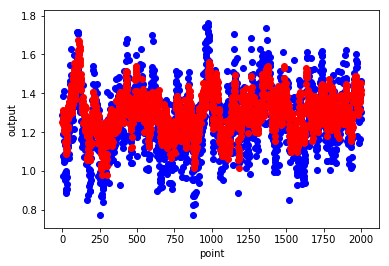

In [6]:
gt_show = [i.cpu().detach().numpy() for k in gt for i in k]
pred_show = [i.cpu().detach().numpy() for k in pred for i in k]
length = 2000
plt.scatter(list(range(length)), gt_show[0:length], c='b')
plt.scatter(list(range(length)), pred_show[0:length], c='r')
plt.xlabel('point')
plt.ylabel('output')
plt.show()
plt.close()

In [6]:

# gt = [i.cpu().detach().numpy() for k in perior_result[0,:] for i in k]
# pred = [i.cpu().detach().numpy() for k in outputs[0,:] for i in k]



In [21]:
pbar.close()

In [26]:
import torch
import sys
from data import train_loader, test_loader, data_train, data_test
from tqdm import tqdm
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
from torch.autograd import Variable

import cv2
slidingWindow = 5

class Process:
    def __init__(self,WindowSize):
        self.delay = 1
        self.slidingWindow = WindowSize
        self.createMatrix()

    def createMatrix(self):  
#         mat = np.random.rand(self.slidingWindow,self.slidingWindow)
#         self.TimeMatrix = torch.from_numpy(np.tril(mat,-1*self.delay))
        mat = np.random.rand(self.slidingWindow)
        self.TimeMatrix = torch.from_numpy(mat.reshape(1,self.slidingWindow))
        self.OneHotMatrix = torch.from_numpy(np.arange(0,10,1.0).reshape(10,1))

    def GetResult(self,labelBatch):
#         onehot = torch.nn.functional.one_hot(labelBatch, 10).double()
#         onehot = self.make_one_hot(labelBatch,10)
        res = torch.mm(self.TimeMatrix,labelBatch.resize(self.slidingWindow,1).double())
        
#         res = torch.mm(res,self.OneHotMatrix)
        res[0] = res[0]/50
        return res

    def make_one_hot(self,input, num_classes):
        """Convert class index tensor to one hot encoding tensor.
        Args:
             input: A tensor of shape [bs, 1, *]
             num_classes: An int of number of class
        Returns:
            A tensor of shape [bs, num_classes, *]
        """
        input.unsqueeze_(1)
        shape = np.zeros((input.shape[0],num_classes))
        result = torch.from_numpy(shape)
        result = result.scatter_(1, input, 1)
        return result
    
    def CalAcc(self,outputs,labels):
        bias = 0
        for i in range(outputs.shape[0]):
            for j in range(outputs.shape[1]):
                bias += pow((outputs[i][j]-labels[i][j]),2)
        bias/=(outputs.shape[0]*outputs.shape[1])
        print("average bias:",bias)
    
class LSTM(torch.nn.Module):
    def __init__(self,slidingWindow):
        super(LSTM, self).__init__()
        # self.cnn_layer = nn.Sequential(
        #     nn.Conv2d(3, 32, kernel_size=3),
        #     nn.ReLU(),
        #     nn.Conv2d(32, 64, kernel_size=3, stride=2),
        #     nn.ReLU(),
        #     nn.Conv2d(64, 64, kernel_size=3, stride=2),
        #     nn.ReLU(),
        #     nn.Conv2d(64, 128, kernel_size=3, stride=2),
        #     nn.ReLU(),
        #     nn.Flatten(),
        #     # nn.Linear(512, 10)
        # )
        self.feature_num = 32
        self.slidingWindow = slidingWindow
        self.lstm = nn.LSTM(1,self.feature_num*2,2,batch_first=True)
        self.fc = nn.Linear(self.feature_num*2,1)
        self.slidingFc = nn.Linear(slidingWindow,1)

    def forward(self, x):
        hidden = (torch.randn(2, 256-self.slidingWindow, self.feature_num*2).cuda(), torch.randn(2, 256-self.slidingWindow, self.feature_num*2).cuda())  # clean out hidden state
        # print("cnn_out",batch)
        # print(batch)
        # batch = self.sig(batch)
        x = x.cuda()
#         print(x)
#         sys.exit()
        x,hidden = self.lstm(x)
        b,s,h = x.shape
        x = x.reshape(s*b, h) # 转换成线性层的输入格式
        x = self.fc(x)
        x = x.reshape(b,s)
        x = self.slidingFc(x)
        x = x.view(b, -1)
        return x    

model = LSTM(slidingWindow).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

epochs = 5
MatrixClass = Process(slidingWindow)
pbar = tqdm(range(1, epochs+1))
gt = []
pred= []
for epoch in pbar:
    running_loss = 0.0
    running_correct = 0
    print("Epoch {}/{}".format(epoch, epochs))
    print("-"*10)    

    for batch_index, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        perior_result = torch.zeros([0,1])
        perior_result = perior_result.cuda()
        label_seq = torch.zeros([0,slidingWindow,1])
        for i in range(len(labels)-slidingWindow):

            result = MatrixClass.GetResult(labels[i:i+slidingWindow])
            label_seq = torch.cat((label_seq,labels[i:i+slidingWindow].view(1,slidingWindow,1).float()))
            result = result.float()
            result = result.cuda()
            perior_result = torch.cat((perior_result,result.view(1,1)))
            # image_sequence[i] = images[i:i+slidingWindow]
        if perior_result.shape[0]!=256-slidingWindow:
            print(perior_result.shape)
            continue
        # image_sequence = image_sequence.cuda()
        label_seq = Variable(label_seq)
        perior_result = Variable(perior_result)
        outputs = model(label_seq)
        # print(outputs)
        optimizer.zero_grad()

        # MatrixClass.CalAcc(outputs,perior_result)
        # print(perior_result.shape,image_sequence.shape)
        loss = criterion(outputs, perior_result)
        loss.backward()
        pbar.set_postfix({'train loss' : '{0:1.5f}'.format(loss)})
        optimizer.step()
        cost = loss.item()
        # print("train lost:",cost)
        # break
        # print(cost)



    for batch_index, (images, labels) in enumerate(test_loader):
        perior_result = torch.zeros([0,1])
        perior_result = perior_result.cuda()
        images = images.cuda()
        label_seq = torch.zeros([0,slidingWindow,1])
        for i in range(len(labels)-slidingWindow):
            result = MatrixClass.GetResult(labels[i:i+slidingWindow])
            label_seq = torch.cat((label_seq,labels[i:i+slidingWindow].view(1,slidingWindow,1).float()))
            result = result.float()
            result = result.cuda()
            perior_result = torch.cat((perior_result,result.view(1,1)))
        if perior_result.shape[0]!=256-slidingWindow:
            print(perior_result.shape)
            continue
        # image_sequence = image_sequence.cuda()
        outputs = model(label_seq)
        pred = outputs
        # print(outputs)
        gt = perior_result
        # MatrixClass.CalAcc(outputs,perior_result)
        # print(perior_result.shape,image_sequence.shape)
        loss = criterion(outputs, perior_result)
        cost = loss.item()
        pbar.set_postfix({'test loss' : '{0:1.5f}'.format(loss)})


  0%|          | 0/5 [00:00<?, ?it/s]/home/cmq/anaconda2/lib/python2.7/site-packages/torch/tensor.py:330: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 1/5
----------


  0%|          | 0/5 [00:15<?, ?it/s, test loss=0.00418] 

torch.Size([91, 1])


 20%|██        | 1/5 [00:17<01:09, 17.29s/it, train loss=0.00484]

torch.Size([11, 1])
Epoch 2/5
----------


 20%|██        | 1/5 [00:31<01:09, 17.29s/it, test loss=0.00436] 

torch.Size([91, 1])


 40%|████      | 2/5 [00:33<00:51, 17.01s/it, train loss=0.00362]

torch.Size([11, 1])
Epoch 3/5
----------


 40%|████      | 2/5 [00:47<00:51, 17.01s/it, test loss=0.00284] 

torch.Size([91, 1])


 60%|██████    | 3/5 [00:50<00:33, 16.83s/it, train loss=0.00274]

torch.Size([11, 1])
Epoch 4/5
----------


 60%|██████    | 3/5 [01:04<00:33, 16.83s/it, test loss=0.00186] 

torch.Size([91, 1])


 80%|████████  | 4/5 [01:06<00:16, 16.64s/it, train loss=0.00197]

torch.Size([11, 1])
Epoch 5/5
----------


 80%|████████  | 4/5 [01:20<00:16, 16.64s/it, test loss=0.00164] 

torch.Size([91, 1])


100%|██████████| 5/5 [01:22<00:00, 16.45s/it, test loss=0.00119]

torch.Size([11, 1])


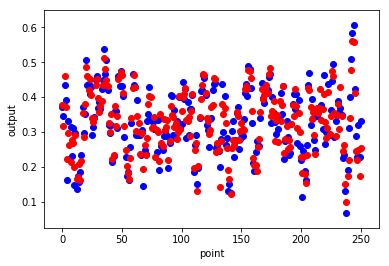

In [27]:
gt_show = gt.cpu().detach().numpy()
pred_show = pred.cpu().detach().numpy()
plt.scatter(list(range(len(gt_show))), gt_show, c='b')
plt.scatter(range(len(pred_show)), pred_show, c='r')
plt.xlabel('point')
plt.ylabel('output')
plt.show()
plt.close()


In [8]:
class Process:
    def __init__(self,WindowSize):
        self.delay = 1
        self.slidingWindow = WindowSize
        self.createMatrix()

    def createMatrix(self):  
#         mat = np.random.rand(self.slidingWindow,self.slidingWindow)
#         self.TimeMatrix = torch.from_numpy(np.tril(mat,-1*self.delay))
        mat = np.random.rand(self.slidingWindow)
        self.TimeMatrix = torch.from_numpy(mat.reshape(1,self.slidingWindow))
        self.OneHotMatrix = torch.from_numpy(np.arange(0,10,1.0).reshape(10,1))

    def GetResult(self,labelBatch):
#         onehot = torch.nn.functional.one_hot(labelBatch, 10).double()
#         onehot = self.make_one_hot(labelBatch,10)
        res = torch.mm(self.TimeMatrix,labelBatch.resize(self.slidingWindow,1).double())
        
#         res = torch.mm(res,self.OneHotMatrix)
        res[0] = res[0]/70
        return res

    def make_one_hot(self,input, num_classes):
        """Convert class index tensor to one hot encoding tensor.
        Args:
             input: A tensor of shape [bs, 1, *]
             num_classes: An int of number of class
        Returns:
            A tensor of shape [bs, num_classes, *]
        """
        input.unsqueeze_(1)
        shape = np.zeros((input.shape[0],num_classes))
        result = torch.from_numpy(shape)
        result = result.scatter_(1, input, 1)
        return result
    
    def CalAcc(self,outputs,labels):
        bias = 0
        for i in range(outputs.shape[0]):
            for j in range(outputs.shape[1]):
                bias += pow((outputs[i][j]-labels[i][j]),2)
        bias/=(outputs.shape[0]*outputs.shape[1])
        print("average bias:",bias)


In [7]:
# -*- coding: utf-8 -*-
"""
Created on Mon Feb  5 19:51:23 2018

@author: Maohan
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt#matplotlib inline
import math
dataset=[]
for data in np.arange(0, 3, .01):
    data = math.sin(data*math.pi)
    dataset.append(data)
dataset=np.array(dataset)
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, dataset))



def create_dataset(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

data_X, data_Y = create_dataset(dataset)

train_size = int(len(data_X) * 0.7)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

import torch

train_X = train_X.reshape(-1, 1, 3)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 3)

train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)
from torch import nn
from torch.autograd import Variable
# 定义模型
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # 回归
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h) # 转换成线性层的输入格式
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x
net = lstm_reg(3, 20)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
# 开始训练
for e in range(1000):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    # 前向传播
    out = net(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
#     if (e + 1) % 100 == 0: # 每 100 次输出结果
    print('Epoch: {}, Loss: {:.10f}'.format(e + 1, loss.item()))
net = net.eval() # 转换成测试模式
data_X = data_X.reshape(-1, 1, 3)
data_X = torch.from_numpy(data_X)
var_data = Variable(data_X)
pred_test = net(var_data) # 测试集的预测结果
# 改变输出的格式
pred_test = pred_test.view(-1).data.numpy()
# 画出实际结果和预测的结果
plt.plot(pred_test, 'r', label='prediction')
plt.plot(dataset[2:], 'b', label='real')
plt.legend(loc='best')

Epoch: 1, Loss: 0.1948765963
Epoch: 2, Loss: 0.1310874522
Epoch: 3, Loss: 0.0921066031
Epoch: 4, Loss: 0.0752919167
Epoch: 5, Loss: 0.0926030651
Epoch: 6, Loss: 0.1531175077
Epoch: 7, Loss: 0.1553135961
Epoch: 8, Loss: 0.1105481237
Epoch: 9, Loss: 0.0677664131
Epoch: 10, Loss: 0.0470048748
Epoch: 11, Loss: 0.0484457798
Epoch: 12, Loss: 0.0638786927
Epoch: 13, Loss: 0.0844824538
Epoch: 14, Loss: 0.1046222672
Epoch: 15, Loss: 0.1217802092
Epoch: 16, Loss: 0.1352922618
Epoch: 17, Loss: 0.1453263015
Epoch: 18, Loss: 0.1523192823
Epoch: 19, Loss: 0.1567424685
Epoch: 20, Loss: 0.1589014828
Epoch: 21, Loss: 0.1585952193
Epoch: 22, Loss: 0.1549298167
Epoch: 23, Loss: 0.1472671181
Epoch: 24, Loss: 0.1365334094
Epoch: 25, Loss: 0.1251643449
Epoch: 26, Loss: 0.1158726513
Epoch: 27, Loss: 0.1102686822
Epoch: 28, Loss: 0.1081067547
Epoch: 29, Loss: 0.1073003113
Epoch: 30, Loss: 0.1045386717
Epoch: 31, Loss: 0.0965646878
Epoch: 32, Loss: 0.0821495056
Epoch: 33, Loss: 0.0634944737
Epoch: 34, Loss: 0.

Epoch: 269, Loss: 0.7551943660
Epoch: 270, Loss: 0.7043594122
Epoch: 271, Loss: 0.6477110982
Epoch: 272, Loss: 0.5863275528
Epoch: 273, Loss: 0.5218550563
Epoch: 274, Loss: 0.4564177394
Epoch: 275, Loss: 0.3922878802
Epoch: 276, Loss: 0.3314740062
Epoch: 277, Loss: 0.2755320966
Epoch: 278, Loss: 0.2229872197
Epoch: 279, Loss: 0.1738862544
Epoch: 280, Loss: 0.1359418333
Epoch: 281, Loss: 0.1060232297
Epoch: 282, Loss: 0.0816535577
Epoch: 283, Loss: 0.0622998662
Epoch: 284, Loss: 0.0481656790
Epoch: 285, Loss: 0.0389127620
Epoch: 286, Loss: 0.0333068520
Epoch: 287, Loss: 0.0327184014
Epoch: 288, Loss: 0.0383969694
Epoch: 289, Loss: 0.0446312204
Epoch: 290, Loss: 0.0531954058
Epoch: 291, Loss: 0.0672030300
Epoch: 292, Loss: 0.0875717774
Epoch: 293, Loss: 0.1135811061
Epoch: 294, Loss: 0.1440231055
Epoch: 295, Loss: 0.1742280424
Epoch: 296, Loss: 0.1915920228
Epoch: 297, Loss: 0.0614795275
Epoch: 298, Loss: 0.0614668131
Epoch: 299, Loss: 0.0633165017
Epoch: 300, Loss: 0.0661568269
Epoch: 3

KeyboardInterrupt: 